<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# To get summaries of the models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Code Challenge: Custom Loss Function

Use the Gausian Autoencoder code from the previous section

Create your own loss function, do not use the ones available in Pytorch: 3 of them

In [2]:
# Create the Gaussian Blurs
# Number of images and image size
nGauss = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# Vary the weights smoothly: Every Gaussian has its own unique parameter
widths = np.linspace(2,20,nGauss)

# Initialize tensots containing images and labels
images = torch.zeros(nGauss,1 ,imgsize, imgsize)

# Create the images
for i in range(nGauss):

    # Create Gaussians with random centers
    ro = 1.5*np.random.randn(2) # ro: random offset
    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i])

    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/5

    # Add Occlusion randomly
    # Any pixel between 2 and 28
    i1 = np.random.choice(np.arange(2,28))
    # Any pixel between 2 and 6
    i2 = np.random.choice(np.arange(2,6))

    # Add the occlusion bar
    if np.random.randn() > 0:
        G[i1:i1+i2,:] = 1
    else:
        G[:,i1:i1+i2] = 1

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)

print(images.shape)

torch.Size([1000, 1, 91, 91])


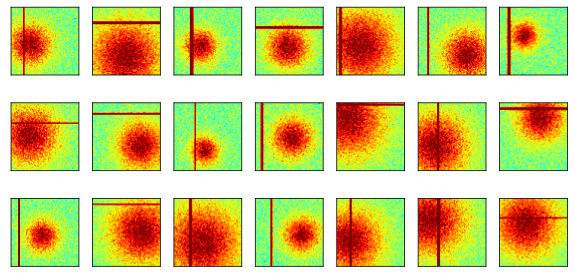

In [3]:
# Show some random images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1,vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Custom Loss Functions

In [4]:
class myL1Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        l = torch.mean(torch.abs(yHat - y))
        return l

In [5]:
class MyL2AveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        # MSE + Average
        l = torch.mean(torch.abs(yHat - y)) + torch.abs(torch.mean(yHat))

        return l

In [6]:
class MyCorrLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        mean_yHat = torch.mean(yHat)
        mean_y = torch.mean(y)
    
        numerator = torch.sum((yHat - mean_yHat)*(y - mean_y))
        # torch.numel() returns the total number of elements in a tensor
        denominator = (torch.numel(y) - 1)*torch.std(yHat)*torch.std(y)
        # We want the correlation to be large, thus negative sign
        return -numerator/denominator

In [7]:
# Create a class for the model
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    lossfun = myL1Loss()
    # lossfun = MyL2AveLoss
    # lossfun = MyCorrLoss

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [8]:
# Create a function to train the model
def function2trainTheModel():

    # Number of epochs: experimental time
    numepochs = 1000

    # create new model instance
    net, lossfun, optimizer = makeTheNet()

    losses = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Pick a set of images at random
        pics2use = np.random.choice(nGauss,size=32,replace=False)
        X = images[pics2use,:,:,:]


        # Forward Pass and Loss
        yHat = net(X)
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)
        losses.append(loss.item())

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # End of epochs loop

    # The final output
    return losses, net

In [9]:
losses, net = function2trainTheModel()

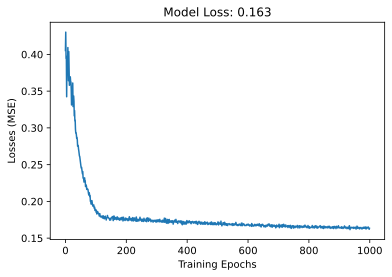

In [10]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

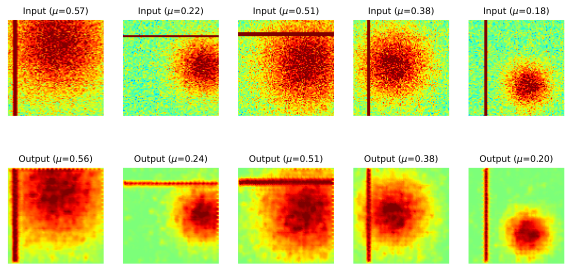

In [11]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,5,figsize=(10,5))

for i in range(5):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()

In [12]:
# Create a class for the model: L2Ave loss
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    # lossfun = myL1Loss()
    lossfun = MyL2AveLoss()
    # lossfun = MyCorrLoss

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [13]:
losses, net = function2trainTheModel()

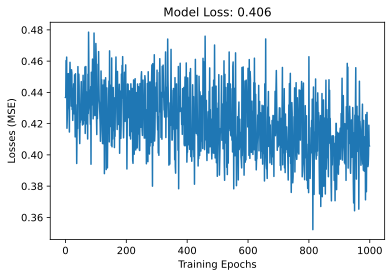

In [14]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

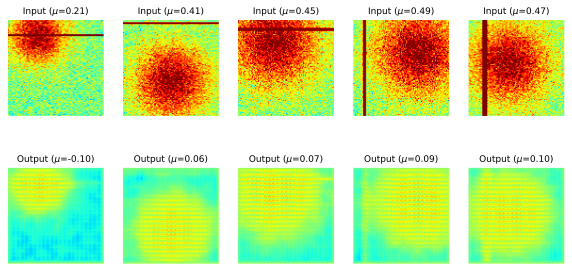

In [15]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,5,figsize=(10,5))

for i in range(5):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()

In [16]:
# Create a class for the model: Correlatio 
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )
            
            # Decoding Layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2)
                )
            
        def forward(self,x):
            return self.dec(self.enc(x))

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    # lossfun = nn.MSELoss()
    # lossfun = myL1Loss()
    # lossfun = MyL2AveLoss()
    lossfun = MyCorrLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [17]:
losses, net = function2trainTheModel()

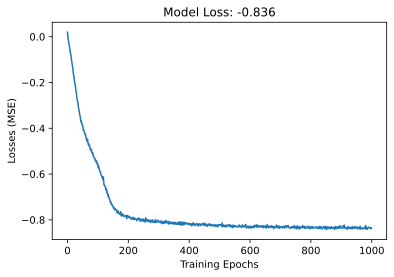

In [18]:
plt.plot(losses, label="Train")
plt.xlabel("Training Epochs")
plt.ylabel("Losses (MSE)")
plt.title(f"Model Loss: {losses[-1]:.3f}")
plt.show()

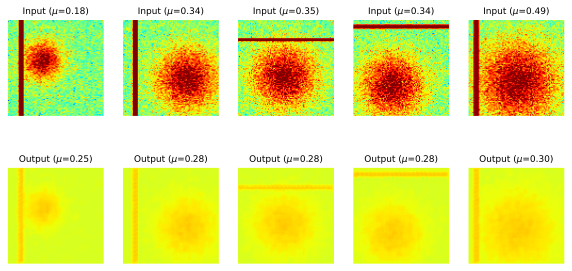

In [19]:
# Pick some random images and visualize them
pics2use = np.random.choice(nGauss, size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,5,figsize=(10,5))

for i in range(5):

    G = torch.squeeze(X[i,0,:,:]).detach()
    O = torch.squeeze(yHat[i,0,:,:]).detach()

    axs[0,i].imshow(G,vmin=-1, vmax=1,cmap="jet")
    axs[0,i].axis("off")
    axs[0,i].set_title("Input ($\mu$=%.2f)"%torch.mean(G).item(),fontsize=9)

    axs[1,i].imshow(O,vmin=-1, vmax=1,cmap="jet")
    axs[1,i].axis("off")
    axs[1,i].set_title("Output ($\mu$=%.2f)"%torch.mean(O).item(),fontsize=9)

plt.show()

# Discover Gaussian Parameters

Use the images code above because we want images without occlusion

In [20]:
# Number of images and image size
nGauss = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# Initialize tensots containing images and labels
images = torch.zeros(nGauss,1 ,imgsize, imgsize)
labels = torch.zeros(nGauss, 3)

# Create the images
for i in range(nGauss):

    # Create Gaussians with random centers
    ro = 2*np.random.randn(2) # ro: random offset
    width = np.random.rand()*10 + 5

    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / width)
    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/10

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)
    # Parameters we want to estimate
    labels[i,:] = torch.tensor([ro[0], ro[1], width])

print(images.shape)
print(labels.shape)

torch.Size([1000, 1, 91, 91])
torch.Size([1000, 3])


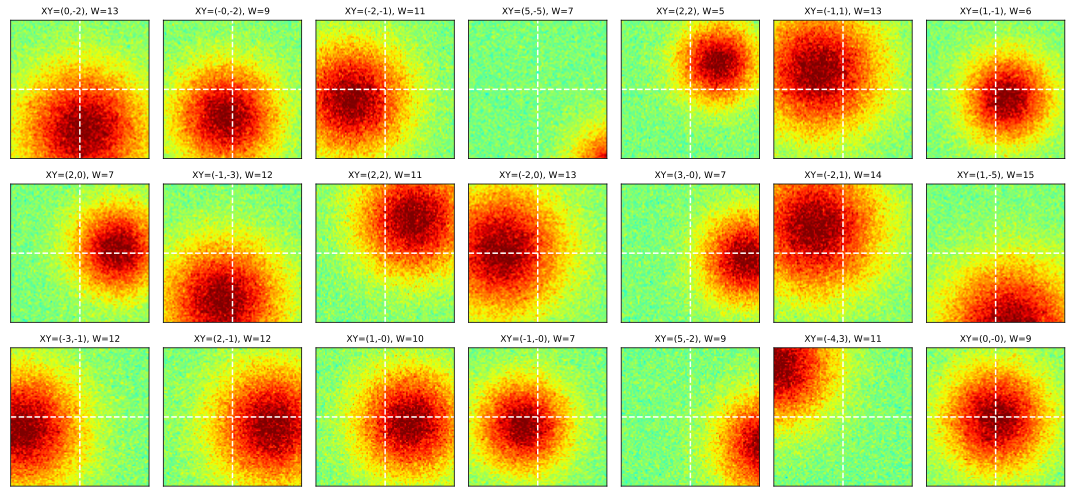

In [21]:
# Show some random images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1,vmax=1, cmap="jet", extent=[-4,4,-4,4], origin="top")
    ax.set_title(f"XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}", fontsize=9)
    ax.plot([-4,4], [0,0], "w--")
    ax.plot([0,0], [-4,4], "w--")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [22]:
# Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [23]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


In [24]:
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([100, 1, 91, 91])
torch.Size([100, 3])


In [25]:
# Create a class for the model
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Encoding Layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),

                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),

                # Linear Decision Layer
                nn.Flatten(),
                nn.Linear(22*22*4,50),
                nn.Linear(50,3),
                )
            
        def forward(self,x):
            return self.enc(x)

    # Create model Instance
    net = GaussNet()

    # Define the loss function
    lossfun = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [26]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

loss = lossfun(yHat,y)

print(yHat.shape)
print(y.shape)
print(loss)

torch.Size([16, 3])
torch.Size([16, 3])
tensor(45.0456, grad_fn=<MseLossBackward0>)


In [27]:
summary(net,(1,imgsize,imgsize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [28]:
def function2trainThemodel():

    # Define the number of epochs
    numepochs = 50

    # Create a new model instance: False by default to avoid printing
    net, lossfun, optimizer = makeTheNet()

    # initialize the losses
    losses = np.zeros((numepochs,2))
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        batchLoss = []

        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())
        # End of he batch loop

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()
    # End the Epochs
    return losses, net

In [29]:
# Run the mode
losses, net = function2trainThemodel()

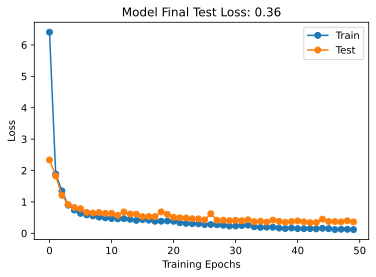

In [30]:
# Visualize it
plt.plot(losses, "o-")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Test"])
plt.title(f"Model Final Test Loss: {losses[:,1][-1]:.2f}")

plt.show()

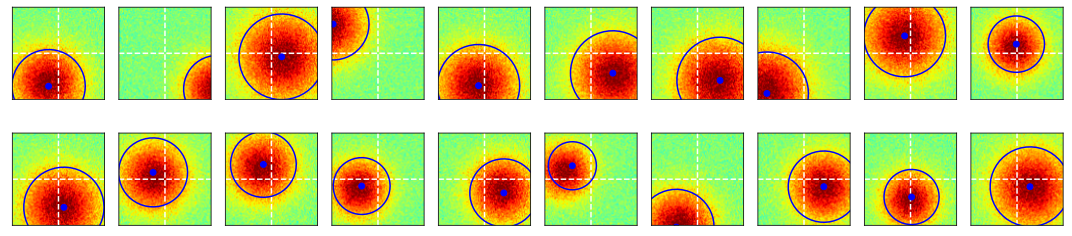

In [31]:
# Visualize some random images

X,Y = next(iter(test_loader))
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

#Theta: phase angle for the circle
th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet', extent=[-4,4,-4,4], origin="top")
    ax.plot([-4,4], [0,0], "w--")
    ax.plot([0,0], [-4,4], "w--")

    # Compute model's prediction for each figure
    cx = yHat[i][0].item()
    cy = yHat[i][1].item()
    rd = yHat[i][2].item()


    # Draw the circle based on predicted parameters
    x = cx + np.cos(th)*np.sqrt(rd)
    y = cy + np.sin(th)*np.sqrt(rd)
    ax.plot(x,y, "b")
    ax.plot(cx,cy, "bo")

    # Make it nice
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

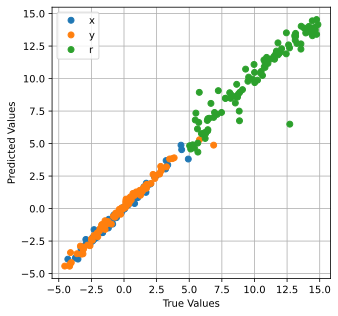

In [32]:
fig = plt.figure(figsize=(5,5))

for i in range(3):

    plt.plot(Y[:,i].detach(),yHat[:,i].detach(), "o")

plt.legend(["x", "y", "r"])
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()